## Models
This notebook is a continuation of the Heart disease project. In the first notebook we did exploratory data analysis, in this notebook we fit a number of models and compare perfomances using different metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import ast
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, cross_validate, learning_curve, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import permutation_importance

from statsmodels.nonparametric.smoothers_lowess import lowess
sys.path.append(os.path.abspath(".."))

from utils.data_utils import CholesterolCleaner, PolynomialFeatureAdder #custom transformers

## Data Structure
As a reminder, our trainining data has 734 observations and 11 features, as shown below. 

In [2]:
X_train =  pd.read_csv("../data/training_features.csv")
y_train = pd.read_csv("../data/training_labels.csv")
full_data = pd.concat([X_train, y_train], axis=1)

In [3]:
X_train.shape

(734, 11)

In [4]:
y_train.shape

(734, 1)

In [5]:
X_train.head(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,70,M,ATA,156,245,0,LVH,143,N,0.0,Up
1,65,M,ASY,135,254,0,LVH,127,N,2.8,Flat


In [6]:
y_train.value_counts(normalize=True)

HeartDisease
1               0.553134
0               0.446866
Name: proportion, dtype: float64

In [7]:
y_train.value_counts()

HeartDisease
1               406
0               328
Name: count, dtype: int64

In [8]:
numerical_vars = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
categorical_vars = [var for var in list(X_train.columns) if var not in numerical_vars]
y_train = y_train.to_numpy().reshape(-1)

### Preprocessing
To start off we apply standard pre-processing techiques to the data:
- for numerical variables  (`Age`, `RestingBP`, `Cholesterol`, `MaxHR`, `Oldpeak`) we scale these to have zero mean and unit variance which ensures that the algorithms are not adversely affected by feature magnitudes.
- we use one-hot encoding for categorical variables (`Sex`, `ChestPainType`, `FastingBS`, `RestingECG`, `ExerciseAngina`, and `ST_Slope`) to ensure they can be properly interpreted by scikit-learn algorithms, which require numerical input.

In [9]:
pipeline_1 = ColumnTransformer([
    ('num', StandardScaler(), numerical_vars),
    ('cat', OneHotEncoder(), categorical_vars)
])
X_train_transformed_1 = pipeline_1.fit_transform(X_train)

In [10]:
X_train_transformed_1

array([[ 1.77969269,  1.26860925,  0.44487182, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.24555202,  0.12781566,  0.52630899, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.17727067,  0.39943318,  0.89730055, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.92506761,  0.29078617,  0.07388026, ...,  0.        ,
         1.        ,  0.        ],
       [-0.14321374,  0.39943318,  0.57155186, ...,  0.        ,
         0.        ,  1.        ],
       [-0.14321374,  2.02913831,  0.24580317, ...,  0.        ,
         1.        ,  0.        ]])

## Logistic Regression Models

We consider the following feature sets for the logistic regression models:

- ### Standard feature set
  This includes scaled numerical predictors and one-hot encoded categorical variables. All feature sets below will apply these transformations, with modifications such as polynomial feature expansion. This feature set is named `X_transformed_1`.

- ### Feature set with imputed `Cholesterol` values
  During exploratory data analysis, we observed that some `Cholesterol` values were recorded as zero—an implausible value in most cases. We treat these zeros as missing (`NaN`) and impute them using the median. This is implemented via a custom transformer `CholesterolCleaner` (see `utils/data_utils.py` for documentation). This feature set is named `X_transformed_2`.

- ### Feature set with polynomial features (`Cholesterol` values unchanged)
  As identified in the exploratory analysis, some continuous predictors show non-linear relationships with the target. Here, we add polynomial features up to degree 3 using a custom transformer `PolynomialFeatureAdder` (see `utils/data_utils.py` for documentation). The original `Cholesterol` values—including zeros—are left unchanged. This feature set is named `X_transformed_3`.

- ### Feature set with polynomial features (`Cholesterol` values imputed)
  This combines the previous two approaches: we first impute the `Cholesterol` values (as in `X_transformed_2`), and then generate polynomial features (as in `X_transformed_3`). The resulting feature set is named `X_transformed_4`.

- ### Feature set with `Cholesterol` column removed.
    In this instance, we entirely exclude the cholesterol column from the feature set. We do not create polynomial features, however. That follows in the next feature set. This one is named `X_train_transformed_5`.

- ### Feature set with `Cholesterol` column removed, with polynomial features.
This is similar to `X_train_transformed_5`, except we have polynomial features for the continuous variables. This is named `X_train_transformed_6`.

- ### Feature set with `Oldpeak` binned
  During EDA we noted that `Oldpeak` had an interesting distribution of values, with the majority (41%) of values being 0. In this feature set, rather than treating this as a continuous variable, we bin it into 5 groups: 'Negative', 'Zero', 'One', 'Two–Three', 'Four+'. This is named `X_train_transformed_7`.
  
- ### Feature set with `Oldpeak` binned, with polynomial features.
  This is the same as above except we add polynomial features for the continuous variables. This is named `X_train_transformed_8`.
  


### Model Setup

We use standard `L2` regularization for all logistic regression models. For each feature set, we perform a grid search over the hyperparameter `C` with values: `0.01`, `0.1`, `1`, `10`, `100`, and `1000`. The parameter `C` controls the amount of regularization (it is the inverse of regularization strength), so smaller values correspond to stronger regularization, as specified in the documentation.

We use **recall** as the scoring metric during grid search, as our goal is to minimize **false negatives**—i.e., patients who actually have heart disease but are incorrectly predicted not to. Recall answers the question:

> *"Of all the patients with heart disease, how many did we correctly identify?"*

A high recall is important in this context, as missing a patient with heart disease could have serious consequences.

Of course, prioritizing recall may reduce precision, meaning more patients without heart disease may be incorrectly flagged as at risk. This trade-off is acceptable in our setting, where the cost of missing a true case outweighs the cost of a false alarm—especially since further medical testing can confirm the diagnosis.

Finally, we extract the best models (one per feature set, four in total) from the grid search and evaluate them using `cross_validate` with `cv=5`. We summarize the following metrics for comparison: `accuracy`, `roc_auc`, `precision`, and `recall`.


### `X_transformed_2`

In [18]:
num_pipeline = Pipeline([('chol_cleaner', CholesterolCleaner()),
('std_scaler', StandardScaler()),
])

pipeline_2 = ColumnTransformer([
("num", num_pipeline, numerical_vars),
("cat", OneHotEncoder(), categorical_vars),
])
X_train_transformed_2 = pipeline_2.fit_transform(X_train)

### `X_transformed_3`

In [11]:
num_pipeline = Pipeline([
    ('poly_adder', PolynomialFeatureAdder(feature_names=numerical_vars, degree=2)),
('std_scaler', StandardScaler()),
])

pipeline_3 = ColumnTransformer([
("num", num_pipeline, numerical_vars),
("cat", OneHotEncoder(), categorical_vars),
])
X_train_transformed_3 = pipeline_3.fit_transform(X_train)

### `X_transformed_4`

In [12]:
num_pipeline = Pipeline([
    ('chol_cleaner', CholesterolCleaner()),
    ('poly_adder', PolynomialFeatureAdder(feature_names=numerical_vars, degree=2)),
('std_scaler', StandardScaler()),
])

pipeline_4 = ColumnTransformer([
("num", num_pipeline, numerical_vars),
("cat", OneHotEncoder(), categorical_vars),
])
X_train_transformed_4 = pipeline_4.fit_transform(X_train)

## Removing cholesterol
### `X_transformed_5`

In [13]:
new_numerical = [var for var in numerical_vars if var !='Cholesterol']
variables = new_numerical + categorical_vars
X_train_no_chol = X_train[variables]


pipeline_5 = ColumnTransformer([
    ('num', StandardScaler(), new_numerical),
    ('cat', OneHotEncoder(), categorical_vars)
])
X_train_transformed_5 = pipeline_5.fit_transform(X_train_no_chol)

### `X_transformed_6`

In [14]:
num_pipeline = Pipeline([
    ('poly_adder', PolynomialFeatureAdder(feature_names=new_numerical, degree=2)),
('std_scaler', StandardScaler()),
])

pipeline_6 = ColumnTransformer([
("num", num_pipeline, new_numerical),
("cat", OneHotEncoder(), categorical_vars),
])
X_train_transformed_6 = pipeline_6.fit_transform(X_train_no_chol)

## Binning `Oldpeak`
### `X_transformed_7`

In [15]:
bins = [-np.inf, -1, 0, 1, 3, np.inf]
labels = ['Negative', 'Zero', 'One', 'Two–Three', 'Four+']
X_train_OP_binned = X_train.copy()
X_train_OP_binned['OldPeak_Binned'] = pd.cut(X_train_OP_binned['Oldpeak'], bins=bins, labels=labels, right=True)
X_train_OP_binned.drop(columns=['Oldpeak'], inplace=True)
X_train_OP_binned.head()
numerical_vars_ = [var for var in numerical_vars if var!='Oldpeak']
categorical_vars_ = categorical_vars + ['OldPeak_Binned']

num_pipeline = Pipeline([('chol_cleaner', CholesterolCleaner()),
('std_scaler', StandardScaler()),
])

pipeline_2 = ColumnTransformer([
("num", num_pipeline, numerical_vars_),
("cat", OneHotEncoder(), categorical_vars_),
])
X_train_transformed_7 = pipeline_2.fit_transform(X_train_OP_binned)

### `X_transformed_8`

In [16]:
num_pipeline = Pipeline([
    ('chol_cleaner', CholesterolCleaner()),
    ('poly_adder', PolynomialFeatureAdder(feature_names=numerical_vars_, degree=2)),
('std_scaler', StandardScaler()),
])

pipeline_4 = ColumnTransformer([
("num", num_pipeline, numerical_vars_),
("cat", OneHotEncoder(), categorical_vars_),
])
X_train_transformed_8 = pipeline_4.fit_transform(X_train_OP_binned)

### Grid Search

In [1]:
param_grid = [{'C': [0.01,0.1,0.5,0.8,1,10, 100, 1000]}]
feature_sets = {
    'baseline': X_train_transformed_1,
    'chol_transformed': X_train_transformed_2,
    'poly_terms': X_train_transformed_3,
    'chol_transformed_poly': X_train_transformed_4,
    'no_chol_baseline': X_train_transformed_5,
    'poly_transformed_no_chol': X_train_transformed_6,
    'op_binned_chol_transformed': X_train_transformed_7,
    'op_binned_chol_transformed_poly': X_train_transformed_8
}

results = {}

for name, X in feature_sets.items():
    grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, scoring='recall', cv=5, return_train_score=True)
    grid.fit(X, y_train)

    best_model = grid.best_estimator_

    metrics = cross_validate(
        best_model, X, y_train, cv=5,
        scoring=['accuracy', 'roc_auc', 'precision', 'recall'],
        return_train_score=True
    )



    results[name] = {
        'model': best_model,
        'C': best_model.C,
        'train_accuracy': metrics['train_accuracy'].mean(),
        'test_accuracy': metrics['test_accuracy'].mean(),
        'train_auc': metrics['train_roc_auc'].mean(),
        'test_auc': metrics['test_roc_auc'].mean(),
        'train_precision': metrics['train_precision'].mean(),
        'test_precision': metrics['test_precision'].mean(),
        'train_recall': metrics['train_recall'].mean(),
        'test_recall': metrics['test_recall'].mean()
    }


NameError: name 'X_train_transformed_1' is not defined

In [20]:
summary_df = pd.DataFrame.from_dict({
    name: {
        'C': model_info['C'],
        #'Train Accuracy': model_info['train_accuracy'],
        'Test Accuracy': model_info['test_accuracy'],
        #'Train ROC AUC': model_info['train_auc'],
        'Test ROC AUC': model_info['test_auc'],
        #'Train Precision': model_info['train_precision'],
        'Test Precision': model_info['test_precision'],
        #'Train Recall': model_info['train_recall'],
        'Test Recall': model_info['test_recall'],
    }
    for name, model_info in results.items()
}, orient='index')

summary_df = summary_df.round(3)


## Comparison of Logistic regression models

As can be seen below, the model with the polynomial terms (`poly_terms`) but with the cholesterol values unchanged perfomed the best using AUC and recall as the metrics. As already alluded to in the previous notebook, one should be wary of these results. We saw that the majority of the people with cholesterol values of 0 had heart disease, yet we know that this value is likely erroneous. Therefore, in a real, practical setting where a practictioner wants to predict the likelihood of heart disease this model is likely not to be as useful since the actual non-zero valid value of cholesterol for the patient would have to be input. The same is applicable for the `baseline` model since the feature set used here also had the `cholesterol` values unchanged.

In [21]:
summary_df

,C,Test Accuracy,Test ROC AUC,Test Precision,Test Recall
baseline,0.5,0.861,0.922,0.864,0.889
chol_transformed,0.1,0.860,0.921,0.860,0.892
poly_terms,0.5,0.866,0.926,0.865,0.899
chol_transformed_poly,0.1,0.861,0.922,0.864,0.889
no_chol_baseline,0.1,0.857,0.922,0.861,0.884
poly_transformed_no_chol,0.5,0.853,0.924,0.856,0.882
op_binned_chol_transformed,0.8,0.868,0.923,0.871,0.894
op_binned_chol_transformed_poly,0.1,0.868,0.920,0.869,0.897


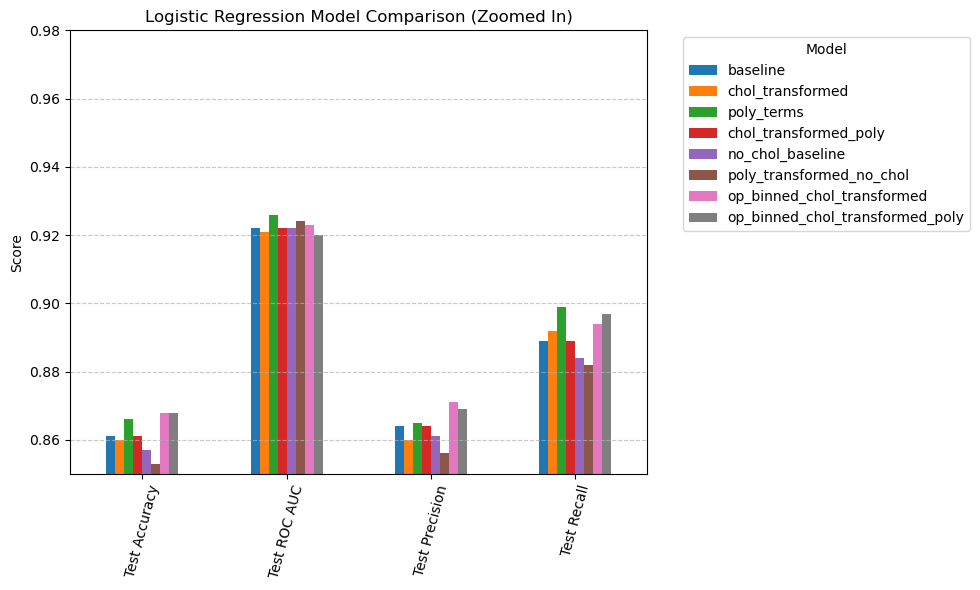

In [34]:
summary_df.drop(columns='C').T.plot(kind='bar', figsize=(10, 6))
plt.ylim(0.85, 0.98)
plt.title('Logistic Regression Model Comparison (Zoomed In)')
plt.ylabel('Score')
plt.xticks(rotation=75)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Learning Curves
Below we plot the learning curves for the different models to check if there is underfitting or overfitting. As seen below, the training and validation curves are converging as we increase the sample size for all the models. This suggests that our models have been properly regularized. Furthermore, as we add more data, the perfomance on the testing data increases which indicates low bias in the models.

In [23]:
del results['baseline']
del results ['poly_terms']


In [108]:
np.linspace(0.1, 1.0, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

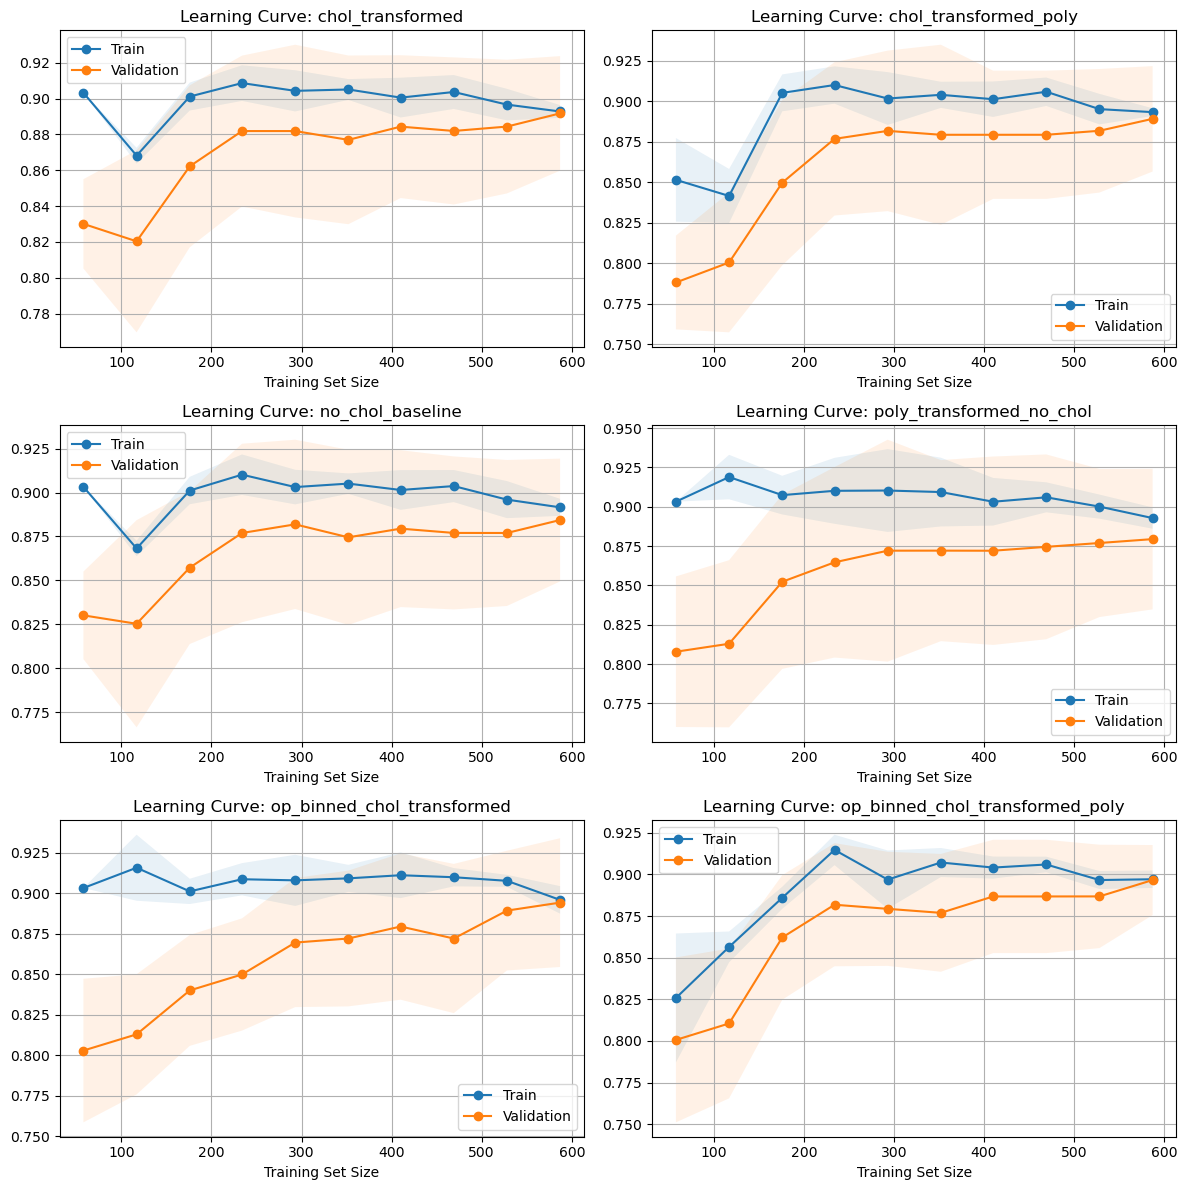

In [24]:
n_models = len(results)
n_cols = 2
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for idx, (name, model_info) in enumerate(results.items()):
    X = feature_sets[name]
    model = model_info['model']

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        scoring="recall",
        return_times=False
    )

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_std = test_scores.std(axis=1)

    ax = axes[idx]
    ax.plot(train_sizes, train_mean, label='Train', marker='o')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)

    ax.plot(train_sizes, test_mean, label='Validation', marker='o')
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    ax.set_title(f'Learning Curve: {name}')
    ax.set_xlabel('Training Set Size')
    #ax.set_ylabel(scoring.capitalize())
    ax.grid(True)
    ax.legend()

# Remove unused subplots if any
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Comparisons continued

Having dropped the two models above, we remain with the six below. The recalls are not that different, ranging from 88.2% to 89.7%. Of these, based on recall the model that used the feature set with `Oldpeak` binned, cholesterol transformed and with polynomial terms performs the best, but only by a small margin. It has a recall of 89.7%. It also has the highest accuracy of 86.8% (which is the same accuracy as the feature set without the polynomial features). 

In [36]:
summary_df_dropped = summary_df.drop(index=['baseline','poly_terms'])
summary_df_dropped

,C,Test Accuracy,Test ROC AUC,Test Precision,Test Recall
chol_transformed,0.1,0.860,0.921,0.860,0.892
chol_transformed_poly,0.1,0.861,0.922,0.864,0.889
no_chol_baseline,0.1,0.857,0.922,0.861,0.884
poly_transformed_no_chol,0.5,0.853,0.924,0.856,0.882
op_binned_chol_transformed,0.8,0.868,0.923,0.871,0.894
op_binned_chol_transformed_poly,0.1,0.868,0.920,0.869,0.897


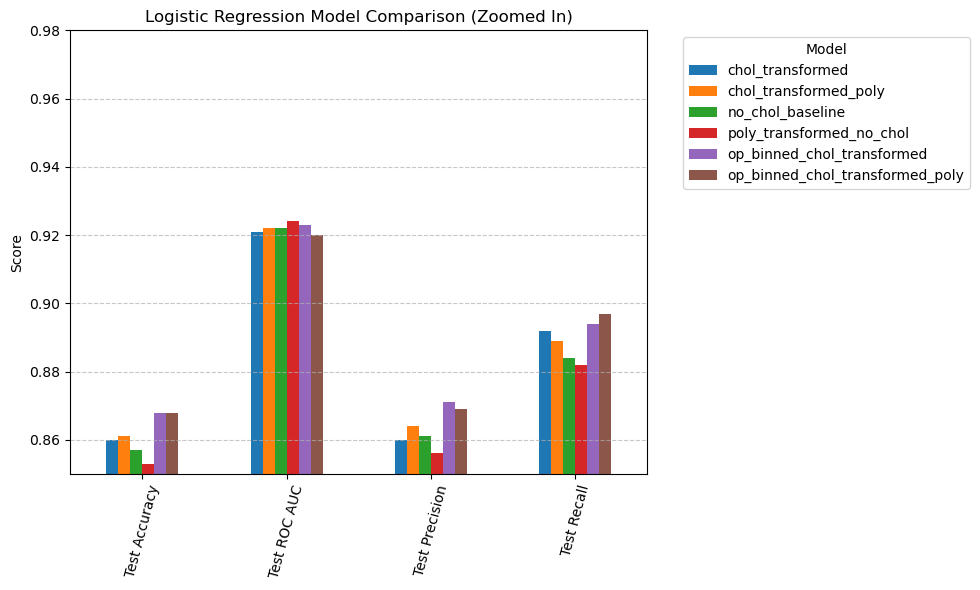

In [37]:
summary_df_dropped.drop(columns='C').T.plot(kind='bar', figsize=(10, 6))
plt.ylim(0.85, 0.98)
plt.title('Logistic Regression Model Comparison (Zoomed In)')
plt.ylabel('Score')
plt.xticks(rotation=75)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Removing the observations with cholesterol equal to 0
In one of the feature sets above we removed the whole `Cholesterol` column. Now we will remove the 145 observations with cholesterol equal to zero. Admitedlly this will make comparisons with the previous models rather difficult because we will now be working with 589 observations as opposed to the 734 we had before. Since these 0 values are likely NAs, in a practical setting should we encounter these zeroes we would rather do as we have done above, i.e. impute or exclude the variable rather than discard the observation.

In [38]:
train_new = full_data[full_data['Cholesterol']>0].copy()
vars_ = numerical_vars + categorical_vars
X_train_new = train_new[vars_]
y_train_new = train_new['HeartDisease']

In [46]:
X_train_OP_binned_new = X_train_OP_binned[X_train_OP_binned['Cholesterol']>0].copy()

In [39]:
X_train_new.shape

(589, 11)

In [41]:
y_train_new.value_counts()

HeartDisease
0    310
1    279
Name: count, dtype: int64

In [42]:
y_train_new = y_train_new.to_numpy().reshape(-1)

In [43]:
pipeline_1 = ColumnTransformer([
    ('num', StandardScaler(), numerical_vars),
    ('cat', OneHotEncoder(), categorical_vars)
])
X_train_transformed_new_1 = pipeline_1.fit_transform(X_train_new)

In [44]:
num_pipeline = Pipeline([
    ('poly_adder', PolynomialFeatureAdder(feature_names=numerical_vars, degree=2)),
('std_scaler', StandardScaler()),
])

pipeline_2 = ColumnTransformer([
("num", num_pipeline, numerical_vars),
("cat", OneHotEncoder(), categorical_vars),
])
X_train_transformed_new_2 = pipeline_2.fit_transform(X_train_new)

In [47]:
pipeline_3 = ColumnTransformer([
    ('num', StandardScaler(), numerical_vars_),
    ('cat', OneHotEncoder(), categorical_vars_)
])
X_train_transformed_new_3 = pipeline_3.fit_transform(X_train_OP_binned_new)


In [48]:
num_pipeline = Pipeline([
    ('poly_adder', PolynomialFeatureAdder(feature_names=numerical_vars_, degree=2)),
('std_scaler', StandardScaler()),
])


pipeline_4 = ColumnTransformer([
("num", num_pipeline, numerical_vars_),
("cat", OneHotEncoder(), categorical_vars_),
])
X_train_transformed_new_4 = pipeline_4.fit_transform(X_train_OP_binned_new)

In [94]:
param_grid = [{'C': [0.01,0.1,0.5,0.8,1,10, 100, 1000]}]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_sets = {
    'baseline': X_train_transformed_new_1,
    'poly_terms': X_train_transformed_new_2,
    'op_binned_basline': X_train_transformed_new_3,
    'op_binned_poly': X_train_transformed_new_4
}

results = {}

for name, X in feature_sets.items():
    grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, scoring='recall', cv=cv, return_train_score=True)
    grid.fit(X, y_train_new)

    best_model = grid.best_estimator_

    metrics = cross_validate(
        best_model, X, y_train_new, cv=5,
        scoring=['accuracy', 'roc_auc', 'precision', 'recall'],
        return_train_score=True
    )



    results[name] = {
        'model': best_model,
        'C': best_model.C,
        'train_accuracy': metrics['train_accuracy'].mean(),
        'test_accuracy': metrics['test_accuracy'].mean(),
        'train_auc': metrics['train_roc_auc'].mean(),
        'test_auc': metrics['test_roc_auc'].mean(),
        'train_precision': metrics['train_precision'].mean(),
        'test_precision': metrics['test_precision'].mean(),
        'train_recall': metrics['train_recall'].mean(),
        'test_recall': metrics['test_recall'].mean()
    }


In [51]:
summary_df = pd.DataFrame.from_dict({
    name: {
        'C': model_info['C'],
        #'Train Accuracy': model_info['train_accuracy'],
        'Test Accuracy': model_info['test_accuracy'],
        #'Train ROC AUC': model_info['train_auc'],
        'Test ROC AUC': model_info['test_auc'],
        #'Train Precision': model_info['train_precision'],
        'Test Precision': model_info['test_precision'],
        #'Train Recall': model_info['train_recall'],
        'Test Recall': model_info['test_recall'],
    }
    for name, model_info in results.items()
}, orient='index')



## Results
The summary below indicates that the Olpeak binned baseline model slightly edges out the other models in most of the metrics used. 

In [52]:
summary_df = summary_df.round(3)
summary_df

,C,Test Accuracy,Test ROC AUC,Test Precision,Test Recall
baseline,10.0,0.859,0.922,0.844,0.864
poly_terms,0.5,0.866,0.924,0.848,0.874
op_binned_basline,0.5,0.871,0.926,0.852,0.882
op_binned_poly,0.8,0.868,0.923,0.850,0.874


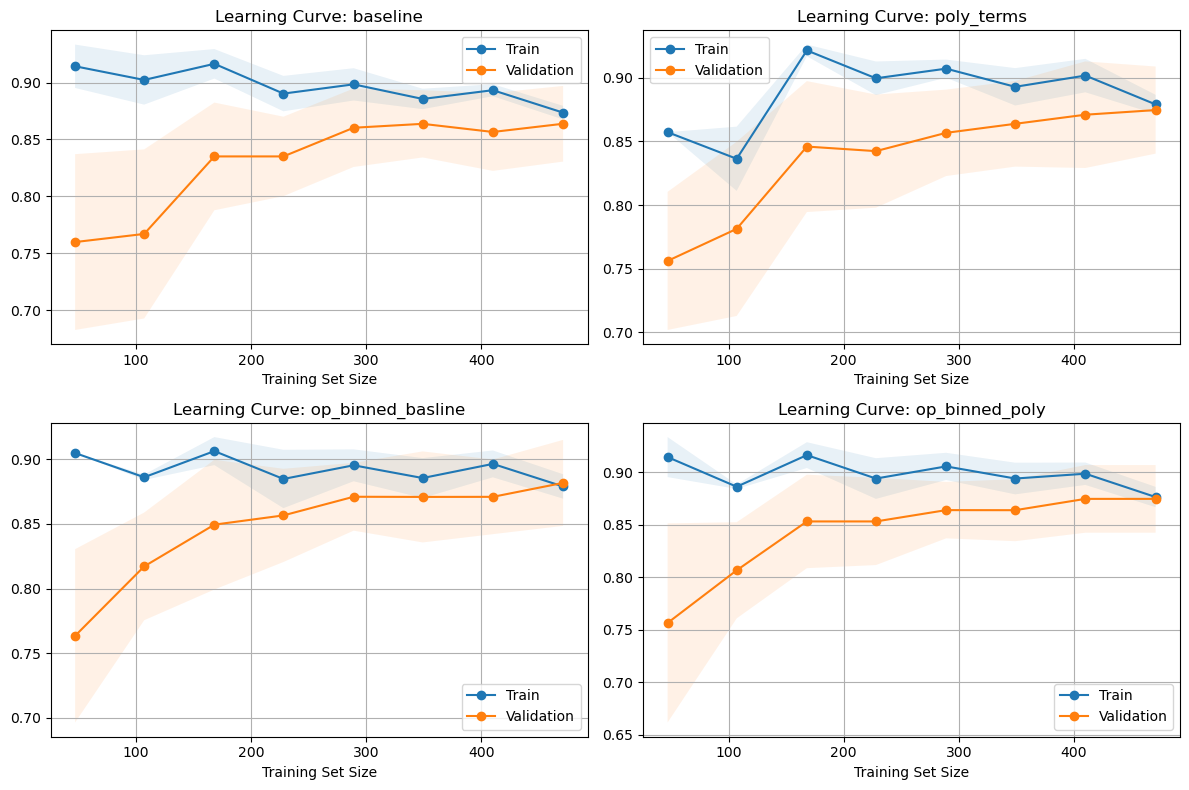

In [53]:
n_models = len(results)
n_cols = 2
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for idx, (name, model_info) in enumerate(results.items()):
    X = feature_sets[name]
    model = model_info['model']

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y_train_new,
        train_sizes=np.linspace(0.1, 1.0, 8),
        cv=5,
        scoring="recall",
        return_times=False
    )

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_std = test_scores.std(axis=1)

    ax = axes[idx]
    ax.plot(train_sizes, train_mean, label='Train', marker='o')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)

    ax.plot(train_sizes, test_mean, label='Validation', marker='o')
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    ax.set_title(f'Learning Curve: {name}')
    ax.set_xlabel('Training Set Size')
    #ax.set_ylabel(scoring.capitalize())
    ax.grid(True)
    ax.legend()

# Remove unused subplots if any
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Random Forests

In [25]:
feature_sets = {
    #'baseline': X_train_transformed_1,
    'chol_transformed': X_train_transformed_2,
    #'poly_terms': X_train_transformed_3,
    'chol_transformed_poly': X_train_transformed_4,
    'no_chol_baseline': X_train_transformed_5,
    'poly_transformed_no_chol': X_train_transformed_6,
    'op_binned_chol_transformed': X_train_transformed_7,
    'op_binned_chol_transformed_poly': X_train_transformed_8
}


In [97]:
param_grid = [
{'n_estimators': [100, 500, 1000], 'max_features': [None, "sqrt", "log2"], 'min_samples_leaf': [ 5, 10, 20]}
]
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, X in feature_sets.items():
    grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, scoring='recall', cv=cv, return_train_score=True)
    grid.fit(X, y_train)

    best_model = grid.best_estimator_

    metrics = cross_validate(
        best_model, X, y_train, cv=5,
        scoring=['accuracy', 'roc_auc', 'precision', 'recall'],
        return_train_score=True
    )

    results[name] = {
        'model': best_model,
        'n_estimators': best_model.n_estimators,
        'max_features': best_model.max_features,
        'min_samples_leaf': best_model.min_samples_leaf,
        'train_accuracy': metrics['train_accuracy'].mean(),
        'test_accuracy': metrics['test_accuracy'].mean(),
        'train_auc': metrics['train_roc_auc'].mean(),
        'test_auc': metrics['test_roc_auc'].mean(),
        'train_precision': metrics['train_precision'].mean(),
        'test_precision': metrics['test_precision'].mean(),
        'train_recall': metrics['train_recall'].mean(),
        'test_recall': metrics['test_recall'].mean()
    }


In [98]:

summary_df = pd.DataFrame.from_dict({
    name: {
        'n_estimators': model_info['n_estimators'],
        'max_features': model_info['max_features'],
        'min_samples_leaf': model_info['min_samples_leaf'],
        'Train Accuracy': model_info['train_accuracy'],
        'Test Accuracy': model_info['test_accuracy'],
        'Train ROC AUC': model_info['train_auc'],
        'Test ROC AUC': model_info['test_auc'],
        'Train Precision': model_info['train_precision'],
        'Test Precision': model_info['test_precision'],
        'Train Recall': model_info['train_recall'],
        'Test Recall': model_info['test_recall'],
    }
    for name, model_info in results.items()
}, orient='index')


summary_df = summary_df.round(3)
summary_df

,n_estimators,max_features,min_samples_leaf,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train Precision,Test Precision,Train Recall,Test Recall
baseline,500,sqrt,10,0.883,0.864,0.957,0.929,0.870,0.849,0.927,0.916
chol_transformed,100,sqrt,5,0.906,0.869,0.973,0.925,0.897,0.862,0.938,0.909
poly_terms,100,log2,20,0.873,0.850,0.949,0.923,0.853,0.829,0.932,0.919
chol_transformed_poly,100,sqrt,20,0.869,0.845,0.946,0.918,0.853,0.832,0.922,0.902
no_chol_baseline,500,sqrt,10,0.875,0.854,0.951,0.924,0.864,0.845,0.918,0.902
poly_transformed_no_chol,500,sqrt,20,0.862,0.846,0.941,0.918,0.847,0.832,0.916,0.904
op_binned_chol_transformed,500,log2,10,0.881,0.860,0.953,0.926,0.870,0.847,0.924,0.911
op_binned_chol_transformed_poly,1000,sqrt,1,1.000,0.865,1.000,0.922,1.000,0.864,1.000,0.899


## Random forests results

From the output below, we note that the range of the recall is 89.9% -- 91.1% - not a huge variance in the models' performance. The feature set with the best recall is `op_binned_chol_transformed` (`Oldpeak` binned, imputed `cholesterol` values) with a recall of 91.1%. The highest recall obtained in the logistic regression models was 89.7%, so it was not far off from the best random forests model. 

Furthermore, for the best recall model, the optimal hyper-parameters are `n_estimators=500`, `max_features=log2` and `min_samples_leaf=10`.

In [100]:
summary_df_dropped = summary_df.drop(index=['baseline','poly_terms'])
summary_df_dropped

,n_estimators,max_features,min_samples_leaf,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train Precision,Test Precision,Train Recall,Test Recall
chol_transformed,100,sqrt,5,0.906,0.869,0.973,0.925,0.897,0.862,0.938,0.909
chol_transformed_poly,100,sqrt,20,0.869,0.845,0.946,0.918,0.853,0.832,0.922,0.902
no_chol_baseline,500,sqrt,10,0.875,0.854,0.951,0.924,0.864,0.845,0.918,0.902
poly_transformed_no_chol,500,sqrt,20,0.862,0.846,0.941,0.918,0.847,0.832,0.916,0.904
op_binned_chol_transformed,500,log2,10,0.881,0.860,0.953,0.926,0.870,0.847,0.924,0.911
op_binned_chol_transformed_poly,1000,sqrt,1,1.000,0.865,1.000,0.922,1.000,0.864,1.000,0.899


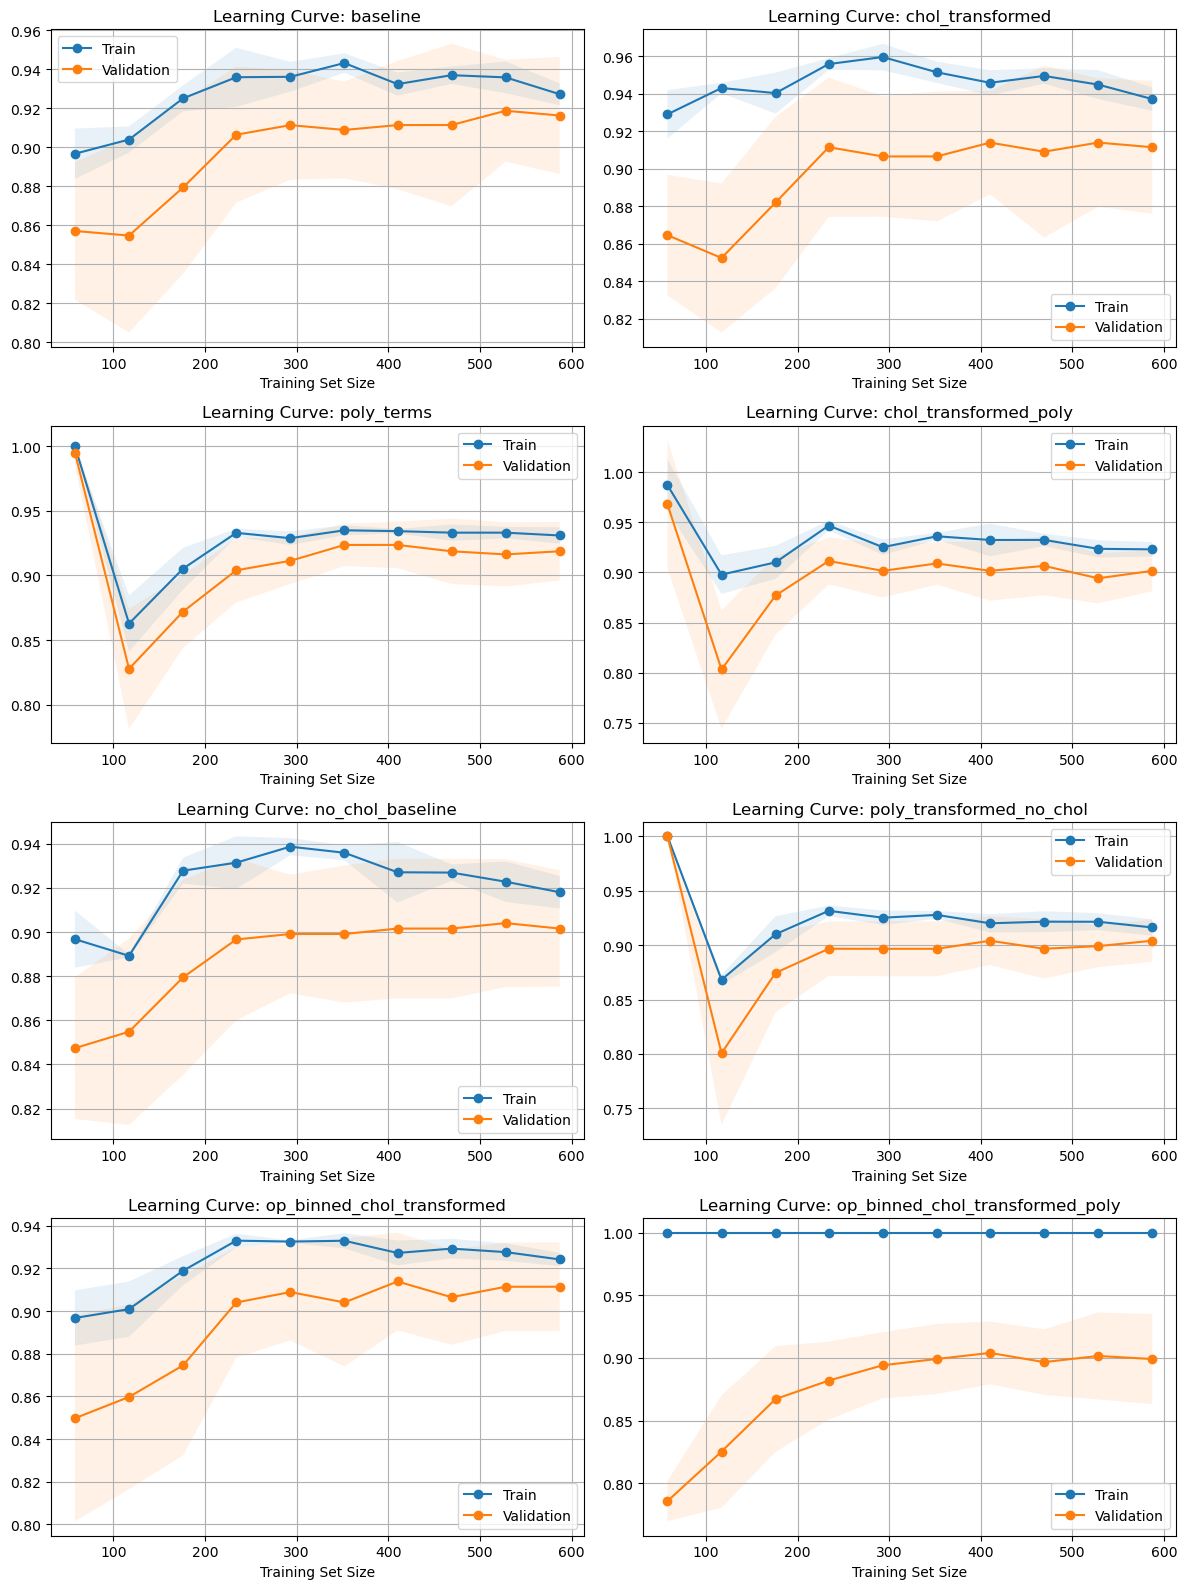

In [109]:
n_models = len(results)
n_cols = 2
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for idx, (name, model_info) in enumerate(results.items()):
    X = feature_sets[name]
    model = model_info['model']

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        scoring="recall",
        return_times=False
    )

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_std = test_scores.std(axis=1)

    ax = axes[idx]
    ax.plot(train_sizes, train_mean, label='Train', marker='o')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)

    ax.plot(train_sizes, test_mean, label='Validation', marker='o')
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    ax.set_title(f'Learning Curve: {name}')
    ax.set_xlabel('Training Set Size')
    #ax.set_ylabel(scoring.capitalize())
    ax.grid(True)
    ax.legend()

# Remove unused subplots if any
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Feature importances
Below we use the feature set that had the best recall and we determine which features were the best at separating the classes. We plot these and observe that the `ST_Slope_Up` variable was ranked the highest. This is in line with what we observed in the exploratory data analysis of the `ST_Slope` categorical variable. Asymptomatic chest pain also has a high importance ranking, coming in third. The polynomial and interaction features we engineered also play an important role: `MaxHR^2` and `Age x Cholesterol` making it into the top 10 features. 

In [105]:
best_rf = results['op_binned_chol_transformed_poly']['model']
num_pipe = pipeline_4.named_transformers_['num']
cat_encoder = pipeline_4.named_transformers_['cat']
poly_adder = num_pipe.named_steps['poly_adder']
num_features = pipeline_4.named_transformers_['num'].named_steps['poly_adder'].get_feature_names_out()
cat_features = pipeline_4.named_transformers_['cat'].get_feature_names_out(categorical_vars_)

feature_names = list(num_features) + list(cat_features)

importances = best_rf.feature_importances_


importances_df = pd.Series(importances, index=feature_names).sort_values()

print("Top ten important features and their importances:\n")
print(importances_df.sort_values(ascending=False).head(10).round(3))  


Top ten important features and their importances:

ST_Slope_Up          0.116
ST_Slope_Flat        0.095
ChestPainType_ASY    0.063
ExerciseAngina_Y     0.047
MaxHR^2              0.043
ExerciseAngina_N     0.042
MaxHR                0.042
Age Cholesterol      0.037
Age RestingBP        0.035
RestingBP MaxHR      0.033
dtype: float64


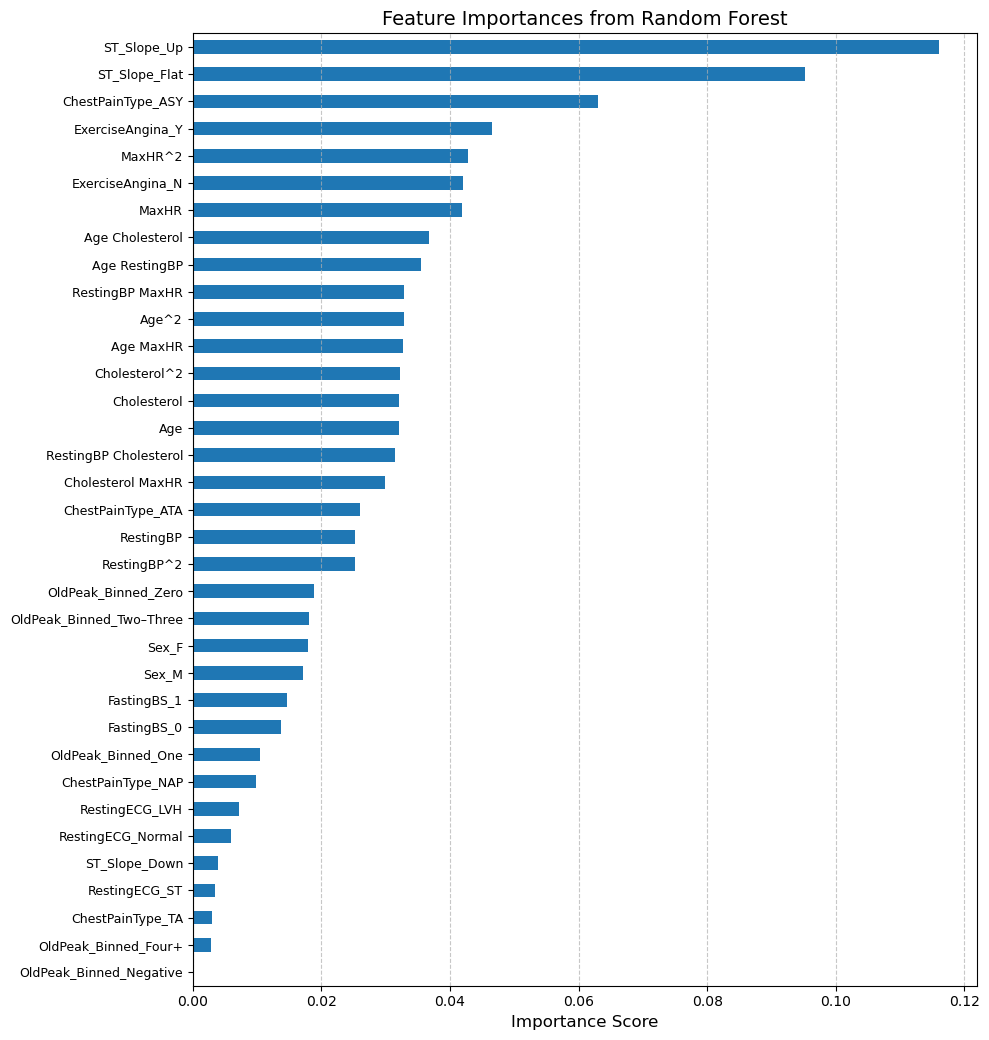

In [102]:
plt.figure(figsize=(10, len(importances_df) * 0.3))  # Dynamic height
ax = importances_df.plot(kind='barh')
plt.title("Feature Importances from Random Forest", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)